# Modelo S Com Data Augmentation

Para o treino deste modelo foi utilizado Data Augmentation, mais especificamente Rotações e Inversões de Imagem.

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, MaxPooling2D, BatchNormalization, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime

# --- Constantes ---
MODEL_NAME = 'ModelS' # Renamed for clarity

BASE_DATASET_PATH = './k_CBIS-DDSM/'
CALC_METADATA_CSV_PATH = os.path.join(BASE_DATASET_PATH, 'calc_case(with_jpg_img).csv')
MASS_METADATA_CSV_PATH = os.path.join(BASE_DATASET_PATH, 'mass_case(with_jpg_img).csv')

IMAGE_ROOT_DIR = BASE_DATASET_PATH
ACTUAL_IMAGE_FILES_BASE_DIR = os.path.join(IMAGE_ROOT_DIR, 'jpg_img')

CONCEPTUAL_ROI_COLUMN_NAME = 'jpg_ROI_img_path'
PATHOLOGY_COLUMN_NAME = 'pathology'
CASE_TYPE_COLUMN_NAME = 'case_type'

# Parametros de treino do modelo
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
EPOCHS = 100 
LEARNING_RATE = 1e-4
RANDOM_STATE = 42
PATIENCE_EARLY_STOPPING = 15
PATIENCE_REDUCE_LR = 7

OUTPUT_DIR = os.path.join('./', f"run_{MODEL_NAME}_{IMG_WIDTH}_{BATCH_SIZE}_BC_A_DataAugmentation_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"All output will be saved to: {os.path.abspath(OUTPUT_DIR)}")

# --- FIM Constantes ---

All output will be saved to: /home/renato/Programming/CBIS-DDSM/run_ModelS_224_64_BC_A_DataAugmentation_20250612_034348


Na seguinte secção foi usada uma função heuristica para corrigir os diretórios inconsistentes no dataset, além disso foram realizadas tecnicas de data augmentation como Rotações e Inversões de Imagem e por fim o dataset foi divido conjuntos de treino (72.25%), validação (12.75%) e teste (15%). 

--- Initial Path Configuration Debug ---
Current working directory (CWD): /home/renato/Programming/CBIS-DDSM
BASE_DATASET_PATH (relative from CWD as defined): ./k_CBIS-DDSM/
CALC_METADATA_CSV_PATH (relative from CWD as defined): ./k_CBIS-DDSM/calc_case(with_jpg_img).csv
MASS_METADATA_CSV_PATH (relative from CWD as defined): ./k_CBIS-DDSM/mass_case(with_jpg_img).csv
IMAGE_ROOT_DIR (relative from CWD as defined): ./k_CBIS-DDSM/
ACTUAL_IMAGE_FILES_BASE_DIR (relative from CWD as defined): ./k_CBIS-DDSM/jpg_img

Resolved BASE_DATASET_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM
  -> Exists? True | Is Dir? True
Resolved CALC_METADATA_CSV_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM/calc_case(with_jpg_img).csv
  -> Exists? True | Is File? True
Resolved MASS_METADATA_CSV_PATH to absolute: /home/renato/Programming/CBIS-DDSM/k_CBIS-DDSM/mass_case(with_jpg_img).csv
  -> Exists? True | Is File? True
Resolved IMAGE_ROOT_DIR to absolute: /home/renato/Programmi

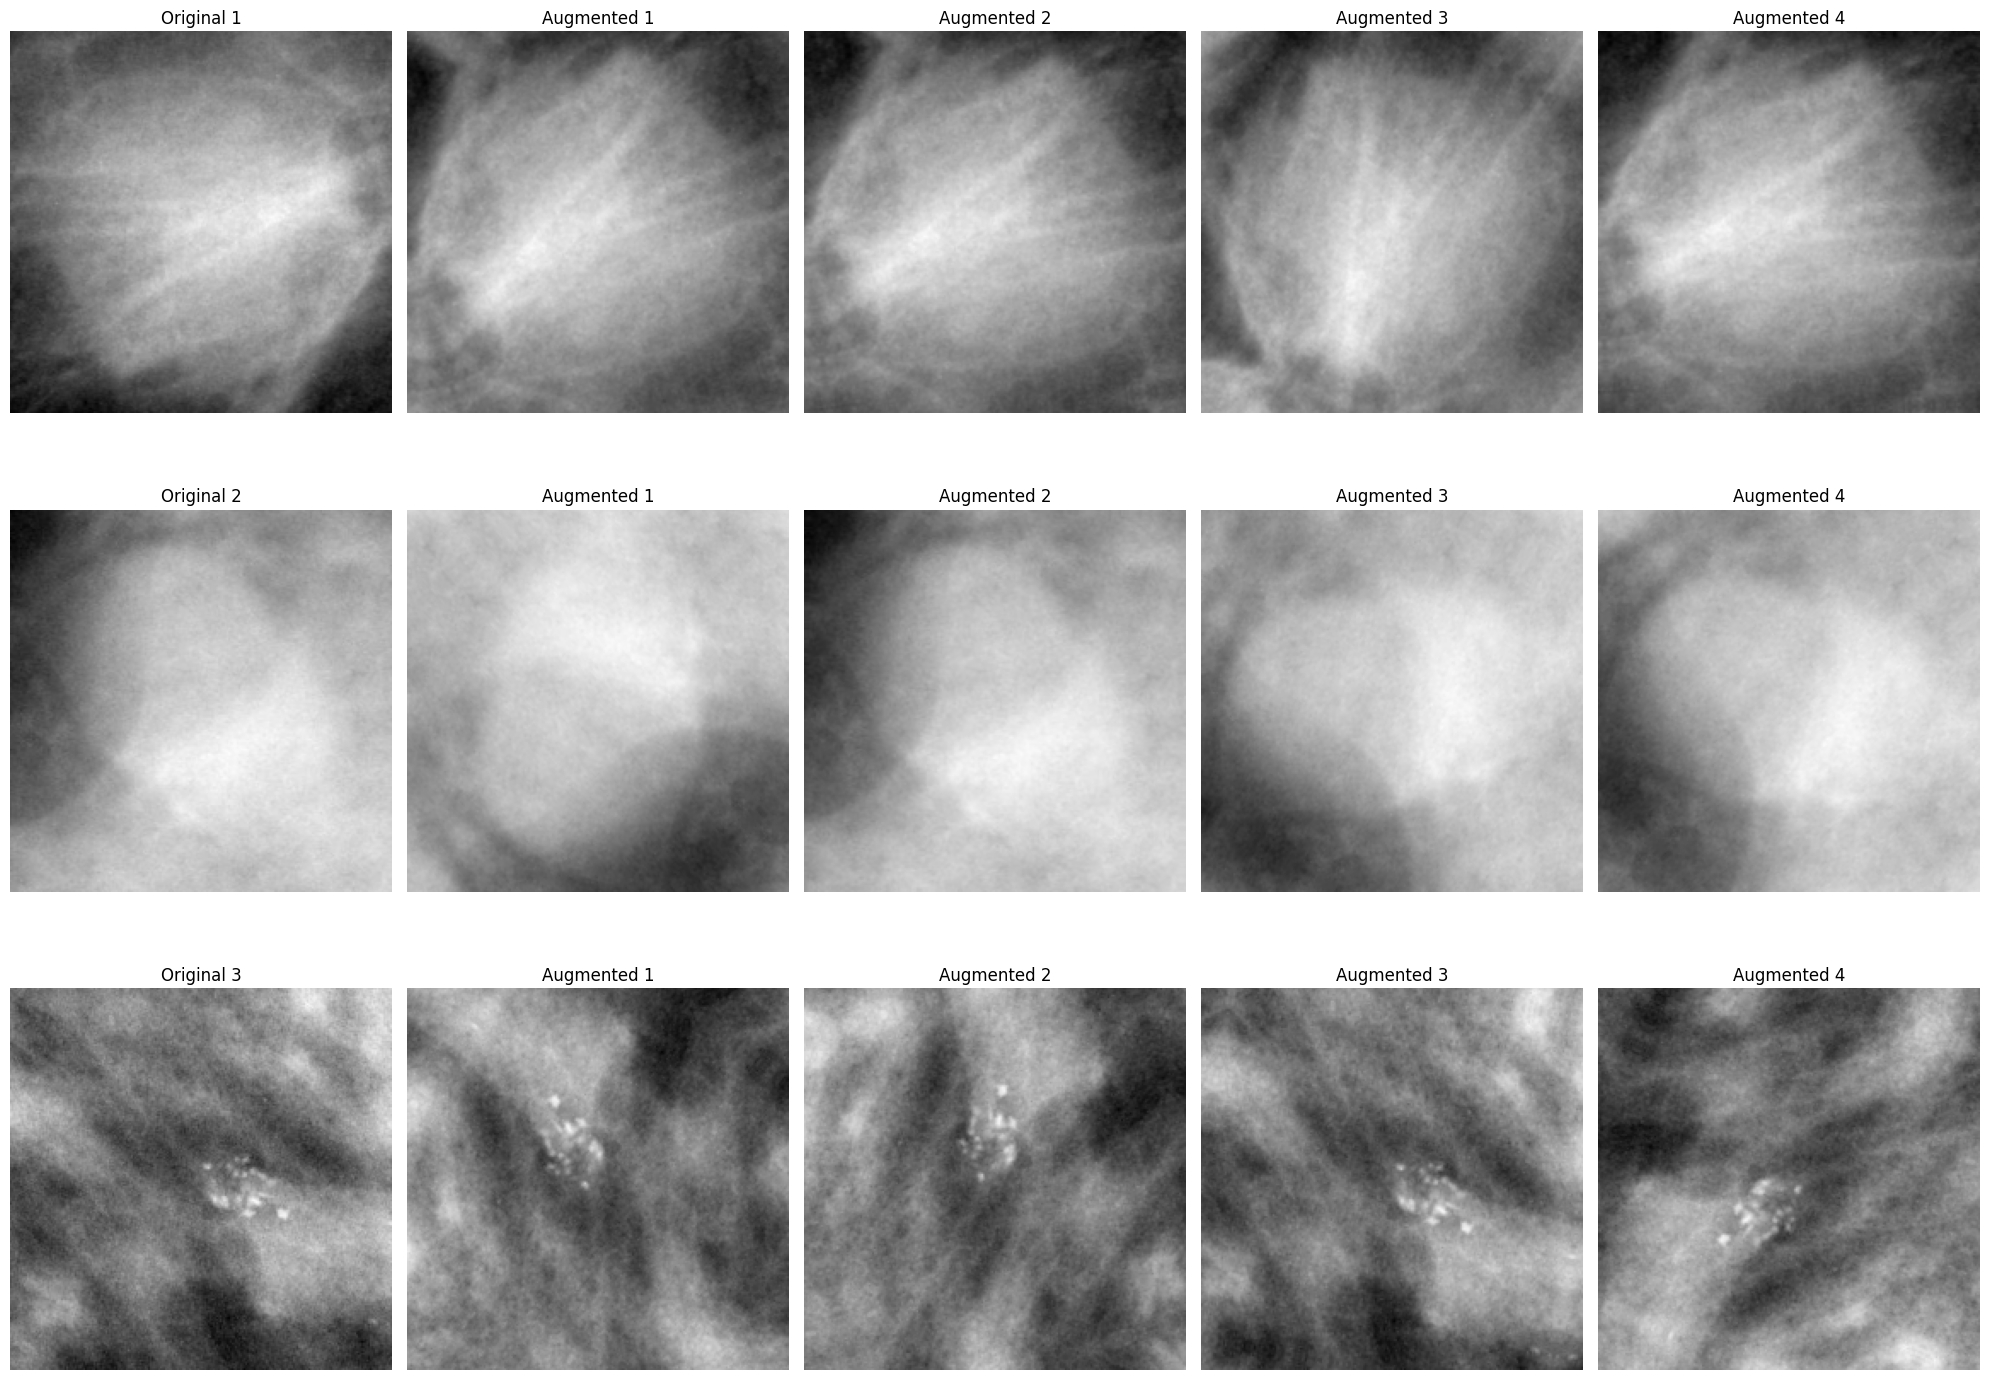

Recreating TensorFlow datasets with updated image loading logic...
Verifying dataset integrity (this might take a moment)...
Number of batches in train_dataset: 33
Effective number of samples in train_dataset after filtering: 2082
Sample batch shape from train_dataset: (64, 224, 224, 3) (64,)
Number of batches in val_dataset: 6
Effective number of samples in val_dataset after filtering: 368
Number of batches in test_dataset: 7
Effective number of samples in test_dataset after filtering: 433


In [8]:
print("--- Initial Path Configuration Debug ---")
print(f"Current working directory (CWD): {os.getcwd()}")
print(f"BASE_DATASET_PATH (relative from CWD as defined): {BASE_DATASET_PATH}")
print(f"CALC_METADATA_CSV_PATH (relative from CWD as defined): {CALC_METADATA_CSV_PATH}") 
print(f"MASS_METADATA_CSV_PATH (relative from CWD as defined): {MASS_METADATA_CSV_PATH}")   # ADDED
print(f"IMAGE_ROOT_DIR (relative from CWD as defined): {IMAGE_ROOT_DIR}")
print(f"ACTUAL_IMAGE_FILES_BASE_DIR (relative from CWD as defined): {ACTUAL_IMAGE_FILES_BASE_DIR}")

abs_base_dataset_path = os.path.abspath(BASE_DATASET_PATH)
abs_calc_metadata_csv_path = os.path.abspath(CALC_METADATA_CSV_PATH) 
abs_mass_metadata_csv_path = os.path.abspath(MASS_METADATA_CSV_PATH)   # ADDED
abs_image_root_dir = os.path.abspath(IMAGE_ROOT_DIR)
abs_actual_image_files_base_dir = os.path.abspath(ACTUAL_IMAGE_FILES_BASE_DIR)

print(f"\nResolved BASE_DATASET_PATH to absolute: {abs_base_dataset_path}")
print(f"  -> Exists? {os.path.exists(abs_base_dataset_path)} | Is Dir? {os.path.isdir(abs_base_dataset_path)}")

print(f"Resolved CALC_METADATA_CSV_PATH to absolute: {abs_calc_metadata_csv_path}") 
print(f"  -> Exists? {os.path.exists(abs_calc_metadata_csv_path)} | Is File? {os.path.isfile(abs_calc_metadata_csv_path)}")

print(f"Resolved MASS_METADATA_CSV_PATH to absolute: {abs_mass_metadata_csv_path}")   # ADDED
print(f"  -> Exists? {os.path.exists(abs_mass_metadata_csv_path)} | Is File? {os.path.isfile(abs_mass_metadata_csv_path)}")

print(f"Resolved IMAGE_ROOT_DIR to absolute: {abs_image_root_dir}")
print(f"  -> Exists? {os.path.exists(abs_image_root_dir)} | Is Dir? {os.path.isdir(abs_image_root_dir)}")

print(f"Resolved ACTUAL_IMAGE_FILES_BASE_DIR (where series folders should be): {abs_actual_image_files_base_dir}")
print(f"  -> Exists? {os.path.exists(abs_actual_image_files_base_dir)} | Is Dir? {os.path.isdir(abs_actual_image_files_base_dir)}")

if os.path.exists(abs_actual_image_files_base_dir) and os.path.isdir(abs_actual_image_files_base_dir):
    print(f"\nSample contents of ACTUAL_IMAGE_FILES_BASE_DIR ('{abs_actual_image_files_base_dir}') (first 10 items):")
    try:
        sample_contents = os.listdir(abs_actual_image_files_base_dir)[:10]
        if not sample_contents:
            print("    -> Directory is empty or unreadable.")
        for item_idx, item in enumerate(sample_contents):
            item_abs_path = os.path.join(abs_actual_image_files_base_dir, item)
            item_type = "Dir" if os.path.isdir(item_abs_path) else "File" if os.path.isfile(item_abs_path) else "Other"
            print(f"    -> [{item_type}] {item}")
    except Exception as e:
        print(f"    -> Could not list directory contents: {e}")
else:
    print("\nCRITICAL WARNING: ACTUAL_IMAGE_FILES_BASE_DIR does not exist or is not a directory. Path searches will fail.")
print("--- End of Initial Path Configuration Debug ---\n")



print("Proceeding with CSV loading...")
loaded_dfs = []

# Load Calc cases
if os.path.exists(abs_calc_metadata_csv_path):
    try:
        calc_df = pd.read_csv(abs_calc_metadata_csv_path)
        calc_df[CASE_TYPE_COLUMN_NAME] = 'calc' # Add case type identifier
        loaded_dfs.append(calc_df)
        print(f"Successfully loaded and tagged {len(calc_df)} rows from {CALC_METADATA_CSV_PATH}")
    except Exception as e:
        print(f"An error occurred while loading the CALC CSV ({CALC_METADATA_CSV_PATH}): {e}")
else:
    print(f"WARNING: CALC CSV file not found at {abs_calc_metadata_csv_path}. Skipping.")

# Load Mass cases
if os.path.exists(abs_mass_metadata_csv_path):
    try:
        mass_df = pd.read_csv(abs_mass_metadata_csv_path)
        mass_df[CASE_TYPE_COLUMN_NAME] = 'mass' # Add case type identifier
        loaded_dfs.append(mass_df)
        print(f"Successfully loaded and tagged {len(mass_df)} rows from {MASS_METADATA_CSV_PATH}")
    except Exception as e:
        print(f"An error occurred while loading the MASS CSV ({MASS_METADATA_CSV_PATH}): {e}")
else:
    print(f"WARNING: MASS CSV file not found at {abs_mass_metadata_csv_path}. Skipping.")

if not loaded_dfs:
    print("ERROR: No CSV files were loaded. Cannot proceed.")
    raise FileNotFoundError("Neither Calc nor Mass CSV files could be loaded. Check paths and file existence.")

source_df = pd.concat(loaded_dfs, ignore_index=True)
print(f"Combined DataFrame created with {len(source_df)} total rows from {len(loaded_dfs)} CSV file(s).")
print(f"Columns available in combined DataFrame: {source_df.columns.tolist()}")



if CONCEPTUAL_ROI_COLUMN_NAME not in source_df.columns or PATHOLOGY_COLUMN_NAME not in source_df.columns:
    print(f"ERROR: Required columns for metadata ('{CONCEPTUAL_ROI_COLUMN_NAME}' or '{PATHOLOGY_COLUMN_NAME}') not in combined CSV.")
    print(f"Available columns are: {source_df.columns.tolist()}")
    raise KeyError("Missing essential columns in combined CSV.")

source_df.dropna(subset=[CONCEPTUAL_ROI_COLUMN_NAME, PATHOLOGY_COLUMN_NAME], inplace=True)
source_df = source_df[source_df[PATHOLOGY_COLUMN_NAME].isin(['MALIGNANT', 'BENIGN'])]
print(f"Rows after initial cleaning (dropna on conceptual ROI/pathology, pathology filter): {len(source_df)}")

if source_df.empty:
    raise ValueError("Combined DataFrame is empty after initial cleaning. Cannot proceed.")

def heuristic_find_image_path(row, actual_images_root_dir_abs):
    try:
        patient_id = row['patient_id']
        breast_side = row['left or right breast']
        image_view = row['image view']
        abnormality_id = str(row['abnormality id']) 

        csv_conceptual_roi_path = str(row.get(CONCEPTUAL_ROI_COLUMN_NAME, "")).strip()

        case_type_folder_prefix = ""
        if csv_conceptual_roi_path.startswith("jpg_img/"):
            path_part = csv_conceptual_roi_path.split('/')[1] 
            
            
            if path_part.startswith("Calc_Training_"): case_type_folder_prefix = "Calc_Training"
            elif path_part.startswith("Calc_Test_"): case_type_folder_prefix = "Calc_Test"
            elif path_part.startswith("Mass_Training_"): case_type_folder_prefix = "Mass_Training"
            elif path_part.startswith("Mass_Test_"): case_type_folder_prefix = "Mass_Test"

        if not case_type_folder_prefix:
            # print(f"DEBUG (heuristic): Could not determine case_type_folder_prefix for {patient_id} from '{csv_conceptual_roi_path}'")
            return None

        dir_search_prefix = f"{case_type_folder_prefix}_{patient_id}_{breast_side}_{image_view}_{abnormality_id}"
        full_dir_search_pattern = os.path.join(actual_images_root_dir_abs, f"{dir_search_prefix}-*")

        potential_series_dirs = glob.glob(full_dir_search_pattern)

        if not potential_series_dirs:
            # print(f"DEBUG (heuristic): No series directory found for {patient_id} with pattern '{full_dir_search_pattern}'")
            return None

        roi_filename_patterns = [
            "ROI-mask-images-img_0-*.jpg", "ROI-mask-images-img_1-*.jpg", "ROI-mask-images-img_*-*.jpg"
        ]

        for series_dir_on_disk in sorted(potential_series_dirs): 
            if os.path.isdir(series_dir_on_disk):
                for pattern in roi_filename_patterns:
                    image_search_glob = os.path.join(series_dir_on_disk, pattern)
                    found_roi_files = glob.glob(image_search_glob)
                    if found_roi_files:
                        found_roi_files.sort() 
                        return found_roi_files[0] 
        return None
    except Exception as e:
        # print(f"DEBUG (heuristic): Error for row {row.get('patient_id', 'Unknown')} ({row.get(CASE_TYPE_COLUMN_NAME, 'N/A')} case): {e}")
        return None

print("Attempting HEURISTIC search for valid ROI paths for each CSV entry...")
source_df['full_image_path'] = source_df.apply(
    lambda r: heuristic_find_image_path(r, abs_actual_image_files_base_dir), axis=1
)

metadata_df = source_df.dropna(subset=['full_image_path']).copy()
found_image_count = len(metadata_df)
print(f"Found {found_image_count} actual image files (ROIs if available) after HEURISTIC search from combined data.")
print(f"Breakdown by case type (if available in metadata_df): \n{metadata_df[CASE_TYPE_COLUMN_NAME].value_counts()}")


if found_image_count == 0:
    print("CRITICAL ERROR: Still no valid image files found even after heuristic search from combined data.")
    raise FileNotFoundError("No usable image files found even with heuristic search from combined data.")

metadata_df.rename(columns={'full_image_path': 'full_roi_path'}, inplace=True)

label_encoder = LabelEncoder()
metadata_df.loc[:, 'pathology_encoded'] = label_encoder.fit_transform(metadata_df[PATHOLOGY_COLUMN_NAME])
target_names = list(label_encoder.classes_)

X = metadata_df['full_roi_path']
y = metadata_df['pathology_encoded']
print(f"Number of samples going into train_test_split: {len(X)}")

if len(X) == 0:
    raise ValueError("Dataset is empty, cannot split.")

# Stratify by y to ensure balanced splits, especially important if classes are imbalanced
# or if combining datasets leads to different proportions.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=RANDOM_STATE, stratify=y_train_val # Stratify this split too
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Print class distribution in each set to verify stratification
print(f"Train labels distribution: {np.bincount(y_train)}")
print(f"Validation labels distribution: {np.bincount(y_val)}")
print(f"Test labels distribution: {np.bincount(y_test)}")


def load_image(image_path_tensor, label_tensor):
    image_path_str = image_path_tensor.numpy().decode('utf-8')
    try:
        img = cv2.imread(image_path_str)
        if img is None:
            return np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8), np.int32(-1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        return img, label_tensor.numpy().astype(np.int32)
    except Exception as e:
        return np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8), np.int32(-1)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

def create_tf_dataset(image_paths, labels, batch_size, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    dataset = dataset.map(lambda x, y: tf.py_function(load_image, [x, y], [tf.uint8, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda img, label: label != -1)

    def set_shape(img, label):
        img.set_shape((IMG_WIDTH, IMG_HEIGHT, 3))
        label.set_shape(())
        return img, label
    dataset = dataset.map(set_shape, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def visualize_augmentations(sample_image_paths, augmentation_layer, output_dir):
    print("Generating and saving data augmentation visualization...")
    num_examples = len(sample_image_paths)
    num_augmentations = 4 
    
    plt.figure(figsize=(5 * num_augmentations, 5 * num_examples))
    
    for i, image_path in enumerate(sample_image_paths):
        # Load the original image using a simplified version of the preprocessing
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        
        # Display the original image
        ax = plt.subplot(num_examples, num_augmentations + 1, i * (num_augmentations + 1) + 1)
        plt.imshow(img)
        plt.title(f"Original {i+1}")
        plt.axis("off")
        
        # Add batch dimension and apply augmentations
        img_tensor = tf.expand_dims(tf.convert_to_tensor(img), 0)
        for j in range(num_augmentations):
            augmented_image = augmentation_layer(img_tensor, training=True)
            ax = plt.subplot(num_examples, num_augmentations + 1, i * (num_augmentations + 1) + j + 2)
            plt.imshow(tf.squeeze(augmented_image, axis=0).numpy().astype("uint8"))
            plt.title(f"Augmented {j+1}")
            plt.axis("off")
            
    plt.tight_layout()
    # Save the figure to the specified output directory
    save_path = os.path.join(output_dir, "data_augmentation_examples.png")
    plt.savefig(save_path)
    print(f"Augmentation visualization saved to {save_path}")
    plt.show()

# --- Call the new visualization function ---
num_viz_samples = 3
if len(X_train) >= num_viz_samples:
    visualize_augmentations(
        sample_image_paths=X_train.iloc[:num_viz_samples],
        augmentation_layer=data_augmentation,
        output_dir=OUTPUT_DIR
    )

print("Recreating TensorFlow datasets with updated image loading logic...")
train_dataset = create_tf_dataset(X_train, y_train, BATCH_SIZE, augment=True)
val_dataset = create_tf_dataset(X_val, y_val, BATCH_SIZE, augment=False)
test_dataset = create_tf_dataset(X_test, y_test, BATCH_SIZE, augment=False)

print("Verifying dataset integrity (this might take a moment)...")
train_batches = 0
train_samples_effective = 0
for images, labels in train_dataset:
    train_batches += 1
    train_samples_effective += labels.shape[0]
print(f"Number of batches in train_dataset: {train_batches}")
print(f"Effective number of samples in train_dataset after filtering: {train_samples_effective}")

if train_batches > 0:
    for images, labels in train_dataset.take(1):
        print("Sample batch shape from train_dataset:", images.shape, labels.shape)
else:
    print("Warning: train_dataset is empty after filtering. Check for widespread image loading issues.")

val_batches = 0
val_samples_effective = 0
for images, labels in val_dataset:
    val_batches +=1
    val_samples_effective += labels.shape[0]
print(f"Number of batches in val_dataset: {val_batches}")
print(f"Effective number of samples in val_dataset after filtering: {val_samples_effective}")


test_batches = 0
test_samples_effective = 0
for images, labels in test_dataset:
    test_batches += 1
    test_samples_effective += labels.shape[0]
print(f"Number of batches in test_dataset: {test_batches}")
print(f"Effective number of samples in test_dataset after filtering: {test_samples_effective}")


# Check if any dataset is empty, which could cause issues during training/evaluation
if train_samples_effective == 0 or val_samples_effective == 0:
    print("CRITICAL WARNING: Training or Validation dataset is empty after processing. Model training cannot proceed effectively.")
    # Depending on the severity, you might want to raise an error here
    # raise ValueError("Training or Validation dataset is empty.")

Nesta secção, definimos a arquitetura do modelo e a estratégia de otimização.

Arquitetura do Modelo:

Camadas Conv2D: Foram utilizados 3 blocos convolucionais (filtros 32→64→128) para a extração hierárquica de características das imagens.

Normalização de Batch: Aplicada após cada camada convolucional para acelerar o treino e melhorar a estabilidade do modelo.

Ativação ReLU: Introduz não-linearidades, permitindo a aprendizagem de padrões complexos.

MaxPooling e GlobalAveragePooling: MaxPooling é usado para reduzir a dimensionalidade espacial, enquanto GlobalAveragePooling minimiza o número de parâmetros antes da classificação.

Dropout: Aplicado com uma taxa de 50% na cabeça de classificação para prevenir overfitting.

Camada de Saída: Uma camada Dense final com ativação Sigmoid para a classificação binária (Maligno/Benigno).

In [9]:
# --- 2. Arquitetura do Modelo S ---
print("\nPhase 2: Building Model S")

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Normalização entre 0 e 1.
x = Rescaling(1./255)(inputs)

# --- Base ---
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# --- End of the Base ---

# --- Start of the Classifier Head ---
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = Dropout(0.5, name="top_dropout_1")(x)
x = Dense(128, activation='relu', name="dense_128")(x)
x = Dropout(0.5, name="top_dropout_2")(x)
outputs = Dense(1, activation='sigmoid', name="predictions")(x)
# --- End of the Classifier Head ---

model = Model(inputs, outputs)


Phase 2: Building Model S


Nesta fase escolhemos o otimizador Adam porque 

In [10]:
# --- 3. Compilação do Modelo ---
print("\nPhase 3: Compiling the Model")
optimizer = Adam(learning_rate=LEARNING_RATE)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()



Phase 3: Compiling the Model


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

O treino foi automatizado e otimizado com callbacks. ModelCheckpoint guardou o modelo com o melhor val_auc, EarlyStopping preveniu o overfitting ao parar o treino após 15 épocas sem melhoria, e ReduceLROnPlateau ajustou dinamicamente a learing rate para uma convergência mais fina.

In [11]:
# --- 4. Treino do Modelo ---
print("\nPhase 4: Training the Custom Model")

checkpoint_filepath = os.path.join(OUTPUT_DIR, 'best_model_from_scratch.keras')
callbacks = [
    ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_auc', mode='max', save_best_only=True),
    EarlyStopping(monitor='val_auc', patience=PATIENCE_EARLY_STOPPING, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE_REDUCE_LR, min_lr=0.01, mode='min')
]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)

print("Loading best weights from training...")
if os.path.exists(checkpoint_filepath):
    model.load_weights(checkpoint_filepath)
else:
    print(f"Warning: Checkpoint file {checkpoint_filepath} not found. Using last model weights.")


Phase 4: Training the Custom Model
Epoch 1/100
     33/Unknown 17s 250ms/step - accuracy: 0.4965 - auc: 0.5077 - loss: 0.8173

/home/renato/Programming/CBIS-DDSM/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.4969 - auc: 0.5081 - loss: 0.8169 - val_accuracy: 0.5054 - val_auc: 0.5020 - val_loss: 0.6935 - learning_rate: 1.0000e-04
Epoch 2/100


2025-06-12 03:44:46.653751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:44:46.653770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - accuracy: 0.5215 - auc: 0.5204 - loss: 0.7866 - val_accuracy: 0.4946 - val_auc: 0.4897 - val_loss: 0.6939 - learning_rate: 1.0000e-04
Epoch 3/100


2025-06-12 03:44:58.298522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:44:58.298544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 415ms/step - accuracy: 0.5043 - auc: 0.5139 - loss: 0.7782 - val_accuracy: 0.4946 - val_auc: 0.4923 - val_loss: 0.6951 - learning_rate: 1.0000e-04
Epoch 4/100


2025-06-12 03:45:12.532725: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:45:12.532746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5092 - auc: 0.5308 - loss: 0.7554

2025-06-12 03:45:23.454465: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:45:23.454486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.5088 - auc: 0.5302 - loss: 0.7556 - val_accuracy: 0.4946 - val_auc: 0.5189 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 5/100


2025-06-12 03:45:25.092153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:45:25.092185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5203 - auc: 0.5150 - loss: 0.7647

2025-06-12 03:45:35.850446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 358ms/step - accuracy: 0.5202 - auc: 0.5151 - loss: 0.7645 - val_accuracy: 0.4946 - val_auc: 0.5241 - val_loss: 0.6952 - learning_rate: 1.0000e-04
Epoch 6/100


2025-06-12 03:45:37.604647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:45:37.604680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5266 - auc: 0.5400 - loss: 0.7327

2025-06-12 03:45:47.653722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:45:47.653746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - accuracy: 0.5266 - auc: 0.5399 - loss: 0.7327 - val_accuracy: 0.4946 - val_auc: 0.5439 - val_loss: 0.6954 - learning_rate: 1.0000e-04
Epoch 7/100


2025-06-12 03:45:49.234395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:45:49.234418: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5243 - auc: 0.5382 - loss: 0.7182

2025-06-12 03:46:01.767511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:46:01.767533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 407ms/step - accuracy: 0.5243 - auc: 0.5381 - loss: 0.7182 - val_accuracy: 0.4946 - val_auc: 0.5465 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 8/100


2025-06-12 03:46:03.286621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:46:03.286642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5023 - auc: 0.5144 - loss: 0.7326

2025-06-12 03:46:14.264186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:46:14.264210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.5025 - auc: 0.5145 - loss: 0.7325 - val_accuracy: 0.4973 - val_auc: 0.5502 - val_loss: 0.6953 - learning_rate: 1.0000e-04
Epoch 9/100


2025-06-12 03:46:15.870057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:46:15.870081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 394ms/step - accuracy: 0.5289 - auc: 0.5349 - loss: 0.7227 - val_accuracy: 0.5272 - val_auc: 0.5463 - val_loss: 0.6958 - learning_rate: 1.0000e-04
Epoch 10/100


2025-06-12 03:46:29.569530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:46:29.569554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5206 - auc: 0.5142 - loss: 0.7219

2025-06-12 03:46:39.776867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.5206 - auc: 0.5144 - loss: 0.7219 - val_accuracy: 0.5190 - val_auc: 0.5487 - val_loss: 0.6915 - learning_rate: 1.0000e-04
Epoch 11/100


2025-06-12 03:46:41.515219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:46:41.515242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.5124 - auc: 0.5243 - loss: 0.7179 - val_accuracy: 0.5380 - val_auc: 0.5537 - val_loss: 0.6892 - learning_rate: 1.0000e-04
Epoch 12/100


2025-06-12 03:46:53.497202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:46:53.497222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.5217 - auc: 0.5229 - loss: 0.7193 - val_accuracy: 0.5190 - val_auc: 0.5480 - val_loss: 0.6869 - learning_rate: 1.0000e-04
Epoch 13/100


2025-06-12 03:47:05.502767: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-06-12 03:47:05.502797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:47:05.502807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.5184 - auc: 0.5490 - loss: 0.7003 - val_accuracy: 0.5299 - val_auc: 0.5412 - val_loss: 0.6888 - learning_rate: 1.0000e-04
Epoch 14/100


2025-06-12 03:47:17.131839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:47:17.131862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5343 - auc: 0.5521 - loss: 0.7038

2025-06-12 03:47:30.331151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:47:30.331176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step - accuracy: 0.5342 - auc: 0.5518 - loss: 0.7039 - val_accuracy: 0.4946 - val_auc: 0.5424 - val_loss: 0.6882 - learning_rate: 1.0000e-04
Epoch 15/100


2025-06-12 03:47:31.984908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:47:31.984929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5308 - auc: 0.5500 - loss: 0.6985

2025-06-12 03:47:42.840918: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:47:42.840945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - accuracy: 0.5307 - auc: 0.5499 - loss: 0.6986 - val_accuracy: 0.5163 - val_auc: 0.5452 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 16/100


2025-06-12 03:47:44.418667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:47:44.418690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.5290 - auc: 0.5527 - loss: 0.6984 - val_accuracy: 0.4973 - val_auc: 0.5485 - val_loss: 0.6927 - learning_rate: 1.0000e-04
Epoch 17/100


2025-06-12 03:47:56.973833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:47:56.973864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5090 - auc: 0.5313 - loss: 0.7053

2025-06-12 03:48:07.193780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:48:07.193826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.5093 - auc: 0.5314 - loss: 0.7053 - val_accuracy: 0.5027 - val_auc: 0.5524 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 18/100


2025-06-12 03:48:09.013550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:48:09.013571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.5344 - auc: 0.5454 - loss: 0.6981 - val_accuracy: 0.5272 - val_auc: 0.5600 - val_loss: 0.6856 - learning_rate: 1.0000e-04
Epoch 19/100


2025-06-12 03:48:22.203712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:48:22.203733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.5159 - auc: 0.5395 - loss: 0.7018 - val_accuracy: 0.5652 - val_auc: 0.5761 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 20/100


2025-06-12 03:48:34.208317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:48:34.208338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.5199 - auc: 0.5377 - loss: 0.6997 - val_accuracy: 0.5408 - val_auc: 0.5778 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 21/100


2025-06-12 03:48:46.662355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:48:46.662380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.5313 - auc: 0.5350 - loss: 0.7049 - val_accuracy: 0.5408 - val_auc: 0.5561 - val_loss: 0.6898 - learning_rate: 1.0000e-04
Epoch 22/100


2025-06-12 03:48:58.512861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:48:58.512883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.5317 - auc: 0.5588 - loss: 0.6907 - val_accuracy: 0.5516 - val_auc: 0.5674 - val_loss: 0.6833 - learning_rate: 1.0000e-04
Epoch 23/100


2025-06-12 03:49:10.418013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:49:10.418036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5500 - auc: 0.5669 - loss: 0.6892

2025-06-12 03:49:21.221576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:49:21.221636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - accuracy: 0.5496 - auc: 0.5666 - loss: 0.6893 - val_accuracy: 0.5082 - val_auc: 0.5682 - val_loss: 0.6846 - learning_rate: 1.0000e-04
Epoch 24/100


2025-06-12 03:49:22.867936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:49:22.867995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5274 - auc: 0.5357 - loss: 0.7010

2025-06-12 03:49:33.312884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step - accuracy: 0.5272 - auc: 0.5358 - loss: 0.7009 - val_accuracy: 0.5082 - val_auc: 0.5599 - val_loss: 0.6845 - learning_rate: 1.0000e-04
Epoch 25/100


2025-06-12 03:49:34.849956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:49:34.849987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step - accuracy: 0.5103 - auc: 0.5302 - loss: 0.6991 - val_accuracy: 0.5571 - val_auc: 0.5649 - val_loss: 0.6826 - learning_rate: 1.0000e-04
Epoch 26/100


2025-06-12 03:49:49.445967: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:49:49.445991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5376 - auc: 0.5539 - loss: 0.6951

2025-06-12 03:50:00.712342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step - accuracy: 0.5374 - auc: 0.5537 - loss: 0.6951 - val_accuracy: 0.5435 - val_auc: 0.5503 - val_loss: 0.6900 - learning_rate: 1.0000e-04
Epoch 27/100


2025-06-12 03:50:02.329219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:50:02.329240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5376 - auc: 0.5460 - loss: 0.6938

2025-06-12 03:50:12.921900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step - accuracy: 0.5372 - auc: 0.5461 - loss: 0.6938 - val_accuracy: 0.5299 - val_auc: 0.5577 - val_loss: 0.6837 - learning_rate: 1.0000e-04
Epoch 28/100


2025-06-12 03:50:14.409624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:50:14.409646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.5421 - auc: 0.5588 - loss: 0.6909 - val_accuracy: 0.5299 - val_auc: 0.5607 - val_loss: 0.6822 - learning_rate: 1.0000e-04
Epoch 29/100


2025-06-12 03:50:26.246044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:50:26.246077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5020 - auc: 0.5244 - loss: 0.7019

2025-06-12 03:50:37.486934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - accuracy: 0.5023 - auc: 0.5247 - loss: 0.7017 - val_accuracy: 0.5109 - val_auc: 0.5435 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 30/100


2025-06-12 03:50:39.068145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:50:39.068165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.5347 - auc: 0.5405 - loss: 0.6966 - val_accuracy: 0.5326 - val_auc: 0.5621 - val_loss: 0.6852 - learning_rate: 1.0000e-04
Epoch 31/100


2025-06-12 03:50:50.983395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:50:50.983415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5448 - auc: 0.5656 - loss: 0.6921

2025-06-12 03:51:01.756847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:01.756871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step - accuracy: 0.5445 - auc: 0.5653 - loss: 0.6921 - val_accuracy: 0.5516 - val_auc: 0.5486 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 32/100


2025-06-12 03:51:03.236090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:03.236121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5161 - auc: 0.5458 - loss: 0.6948

2025-06-12 03:51:13.778327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:13.778349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 350ms/step - accuracy: 0.5166 - auc: 0.5461 - loss: 0.6946 - val_accuracy: 0.5543 - val_auc: 0.5718 - val_loss: 0.6814 - learning_rate: 1.0000e-04
Epoch 33/100


2025-06-12 03:51:15.352132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:15.352164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5310 - auc: 0.5545 - loss: 0.6920

2025-06-12 03:51:25.881735: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:25.881763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.5313 - auc: 0.5546 - loss: 0.6919 - val_accuracy: 0.5054 - val_auc: 0.5535 - val_loss: 0.6851 - learning_rate: 1.0000e-04
Epoch 34/100


2025-06-12 03:51:27.356021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:27.356049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.5158 - auc: 0.5410 - loss: 0.6965 - val_accuracy: 0.5136 - val_auc: 0.5519 - val_loss: 0.6862 - learning_rate: 1.0000e-04
Epoch 35/100


2025-06-12 03:51:40.065590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:40.065632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5450 - auc: 0.5679 - loss: 0.6895

2025-06-12 03:51:50.094407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:50.094429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - accuracy: 0.5454 - auc: 0.5681 - loss: 0.6895 - val_accuracy: 0.5380 - val_auc: 0.5529 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Loading best weights from training...


2025-06-12 03:51:51.674967: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:51.674987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


Por ultimo o modelo foi avaliado


Phase 5: Evaluating the Model on Test Set
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.5212 - auc: 0.5349 - loss: 0.6912
Error: Not enough metrics returned from model.evaluate
Number of results: 3
Results: [0.6897169947624207, 0.519630491733551, 0.5555685758590698]


2025-06-12 03:51:54.233498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10839958340310005780
2025-06-12 03:51:54.233520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10945592397186439906


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

      BENIGN       0.51      0.77      0.61       215
   MALIGNANT       0.55      0.28      0.37       218

    accuracy                           0.52       433
   macro avg       0.53      0.52      0.49       433
weighted avg       0.53      0.52      0.49       433


Confusion Matrix (Test Set):
[[165  50]
 [158  60]]
Confusion matrix saved to ./run_ModelS_224_64_BC_A_DataAugmentation_20250612_034348/confusion_matrix.png


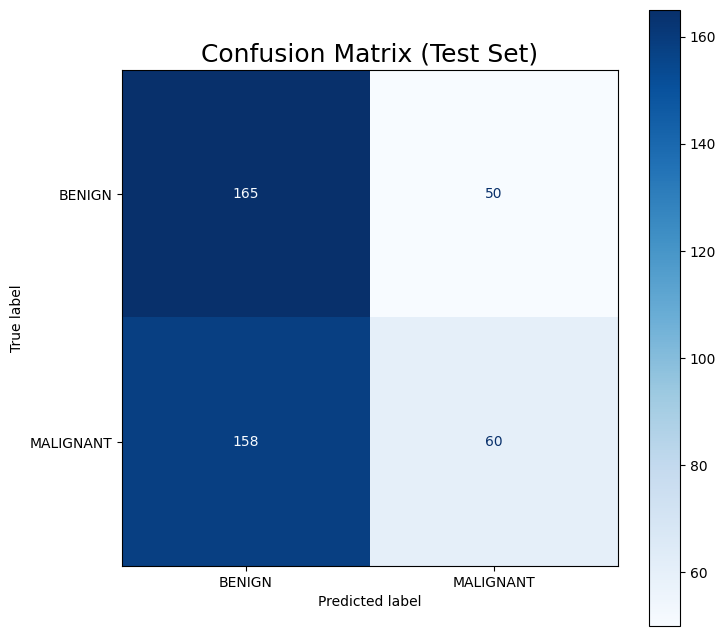

No training history found to plot.

--- End of Training ---


In [12]:
# --- 5. Avaliação do Modelo ---
print("\nPhase 5: Evaluating the Model on Test Set")

if test_samples_effective == 0:
    print("ERROR: Test dataset is empty. Cannot evaluate model.")
    test_accuracy = 0
    test_auc = 0
else:
    results = model.evaluate(test_dataset, verbose=1)
    if len(results) >= 5: 
        final_loss = results[0]
        final_acc = results[1]  # Accuracy
        final_auc = results[2]  # AUC
        final_precision = results[3]  # Precision
        final_recall = results[4]  # Recall
        print(f"Final Loss: {final_loss}")
        print(f"Final Accuracy: {final_acc}")
        print(f"Final AUC: {final_auc}")
        print(f"Final Precision: {final_precision}")
        print(f"Final Recall: {final_recall}")
        history_plot_filename = f"training_history_Acc{final_acc:.3f}_AUC{final_auc:.3f}.png"
    else:
        print("Error: Not enough metrics returned from model.evaluate")

    print("Number of results:", len(results))
    print("Results:", results)
    y_pred_proba = model.predict(test_dataset)

    y_true_test = []
    for _, labels_batch in test_dataset.unbatch().batch(BATCH_SIZE): 
        y_true_test.extend(labels_batch.numpy())
    y_true_test = np.array(y_true_test)

    if len(target_names) <= 2: # Binary classification
        y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()
    else: # Multiclass classification
        y_pred_classes = np.argmax(y_pred_proba, axis=1)


    if len(y_true_test) == 0:
        print("Warning: No true labels extracted from the test set. Cannot generate classification report or confusion matrix.")
    elif len(y_true_test) != len(y_pred_classes):
        print(f"Warning: Mismatch in number of true labels ({len(y_true_test)}) and predicted classes ({len(y_pred_classes)}). Skipping report/matrix.")
    else:
        print("\nClassification Report (Test Set):")
        print(classification_report(y_true_test, y_pred_classes, target_names=target_names, labels=range(len(target_names))))


        cm = confusion_matrix(y_true_test, y_pred_classes, labels=range(len(target_names)))
        print("\nConfusion Matrix (Test Set):")
        print(cm)

        plt.figure(figsize=(8,8))
        ax = plt.gca()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
        plt.title('Confusion Matrix (Test Set)', fontsize=18)
        
    
        cm_save_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
        plt.savefig(cm_save_path)
        print(f"Confusion matrix saved to {cm_save_path}")
        plt.show()


# Plot Training History
acc, val_acc, loss_hist, val_loss_hist, auc, val_auc = [], [], [], [], [], []
epochs_range_head_len = 0
epochs_range_total = range(len(acc))

if epochs_range_total: # Only plot if there's history
    plt.figure(figsize=(20, 8)) 

    # Plot Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range_total, acc, label='Training Accuracy')
    plt.plot(epochs_range_total, val_acc, label='Validation Accuracy')
    if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
        plt.axvline(x=epochs_range_head_len -1 , color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range_total, loss_hist, label='Training Loss')
    plt.plot(epochs_range_total, val_loss_hist, label='Validation Loss')
    if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
        plt.axvline(x=epochs_range_head_len -1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot AUC
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range_total, auc, label='Training AUC')
    plt.plot(epochs_range_total, val_auc, label='Validation AUC')
    if epochs_range_head_len > 0 and epochs_range_head_len < len(epochs_range_total):
        plt.axvline(x=epochs_range_head_len-1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')

    plt.tight_layout()
    

    print("Available metrics names:", model.metrics_names)
    final_acc = results[1]  # Accuracy
    final_auc = results[2]  # AUC
    history_plot_filename = f"training_history_Acc{final_acc:.3f}_AUC{final_auc:.3f}.png"
    history_save_path = os.path.join(OUTPUT_DIR, history_plot_filename)
    plt.savefig(history_save_path)
    print(f"Training history plot saved to {history_save_path}")
    
    plt.show()
else:
    print("No training history found to plot.")

print("\n--- End of Training ---")